In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sp
import os
%load_ext autoreload
%autoreload 2

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/coderepo/ATom/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Acoustic tomography functions
import atom_functions as atom
# import TDSI as TDSI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
datapath = '../../data/20180928_processed_data/'
ttfiles = [datapath+file for file in os.listdir(datapath) if 'filtered_tt' in file]

In [4]:
tmp = TDSI.meanField(ttfiles[0])

NameError: name 'TDSI' is not defined

In [5]:
pathID = np.random.randint(64)
tt_path = tmp.travel_times.xs(pathID, level=2).T
tt_path.plot()

NameError: name 'tmp' is not defined

In [ ]:
tmp.path_lengths.round(2)#.flatten()

In [ ]:
path_velocity = pd.DataFrame()
for col in tmp.travel_times.columns:
    path_velocity[col] =tmp.path_lengths.flatten()/(tmp.travel_times[col]/1000)

In [ ]:
path_velocity.T.mean().plot()

In [177]:
tmp.travel_times['frame 0'].values.reshape(8,8).round(2)

array([[  3.63,  89.6 , 128.99, 224.54, 232.62, 236.92, 199.04, 123.52],
       [ 95.2 ,   2.84,  69.71, 196.06, 231.14, 276.42, 267.76, 213.07],
       [135.26,  73.6 ,   2.88, 128.04, 169.95, 238.54, 248.1 , 232.72],
       [220.82, 192.1 , 124.6 ,   9.49,  67.88, 176.54, 227.96, 272.96],
       [232.61, 229.41, 168.93,  82.5 ,   2.8 , 108.28, 178.5 , 250.99],
       [232.46, 270.63, 233.34, 180.76, 115.38,   2.86,  82.38, 192.86],
       [193.68, 257.26, 241.57, 229.2 , 178.27,  85.92,   2.82, 119.81],
       [117.22, 204.65, 224.97, 274.08, 248.98, 195.71, 107.66,   3.66]])

In [57]:
path_velocity.shape

(64, 120)

In [78]:
pathx = np.abs(np.repeat(tmp.mic_xy_m[:,0][:,np.newaxis],8,axis=1) - np.repeat(tmp.speaker_xy_m[:,0][:,np.newaxis],8,axis=1).T)
pathy = np.abs(np.repeat(tmp.mic_xy_m[:,1][:,np.newaxis],8,axis=1) - np.repeat(tmp.speaker_xy_m[:,1][:,np.newaxis],8,axis=1).T)

In [138]:
G = np.ones((56,3))

G[:,1] = pathx[~np.eye(pathx.shape[0],dtype=bool)].reshape(pathx.shape[0],-1).flatten()
G[:,2] = pathy[~np.eye(pathy.shape[0],dtype=bool)].reshape(pathy.shape[0],-1).flatten()

Ginv = np.linalg.pinv(G)

In [231]:
# pick a frame to look at
frameID=0
pv = path_velocity['frame 0']
pv[::9] = np.NaN
# D = 1/C
D = 1/pv.dropna()
# aver = average values of [1/c0, vx/c0**2, vy/c0**2]
aver = np.matmul(Ginv,D)
# Di is the least-squares estiamte of D
Di = np.matmul(G,aver)
# Residual and rmse
residual = D-Di
rmse = np.linalg.norm(residual)/(tmp.npaths-3)


In [242]:
Ginv.shape

(3, 56)

In [240]:
D


speaker  mic  pathID
S1       M0   1         0.002854
S2       M0   2         0.002857
S3       M0   3         0.002953
S4       M0   4         0.002889
S5       M0   5         0.002906
S6       M0   6         0.002903
S7       M0   7         0.002924
S0       M1   8         0.002928
S2       M1   10        0.002900
S3       M1   11        0.002973
S4       M1   12        0.002906
S5       M1   13        0.002912
S6       M1   14        0.002953
S7       M1   15        0.002915
S0       M2   16        0.002923
S1       M2   17        0.002897
S3       M2   19        0.003054
S4       M2   20        0.002906
S5       M2   21        0.002923
S6       M2   22        0.002924
S7       M2   23        0.002923
S0       M3   24        0.002881
S1       M3   25        0.002868
S2       M3   26        0.002889
S4       M3   28        0.002935
S5       M3   29        0.002917
S6       M3   30        0.002923
S7       M3   31        0.002906
S0       M4   32        0.002880
S1       M4   33      

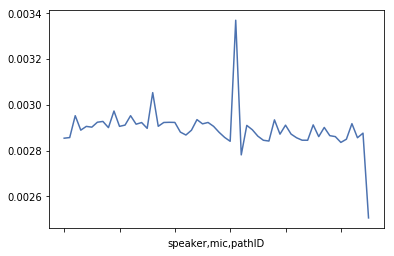

In [234]:
D.plot()

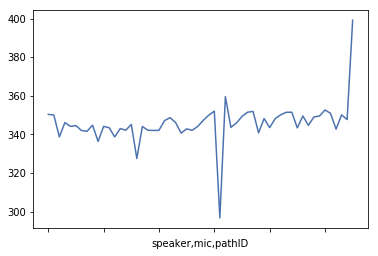

In [236]:
pv.dropna().plot()

In [141]:
# estimated speed of sound during frame
c0est = 1/aver[0]

# error of each term in Aver
std_aver = np.sqrt(rmse*np.diag(np.matmul(Ginv,Ginv.T)))

err_c0 = std_aver[0]*c0est**2
err_c2 = 2*c0est*err_c0

In [147]:
std_aver[0]*c0est

0.4425680576019211

In [148]:
# gamma = Cp/Ct ratio of specific heats of air
gamma = 1.4
# Gas constant for air
Ra = 287.058
gR = gamma*Ra

In [153]:
# estimate of mean temperature from data
T0est = c0est**2/gR
# error estiamte of T
err_T = err_c2/gR

In [160]:
# mean field estimates of vx and vy
vx0est = aver[1]*c0est**2
vy0est = aver[2]*c0est**2

# error of mean field estimates of vx and vy
err_vx = c0est**2*std_aver[1]
err_vy = c0est**2*std_aver[2]

In [221]:
c0est

341.4509934910594

In [220]:
vx0est

-0.06610654271364218

In [224]:
T0est-273.15

16.957576457996822

In [169]:
pathlengths = np.sqrt(pathx**2 + pathy**2)
pathlengths = pathlengths[~np.eye(pathlengths.shape[0],dtype=bool)].reshape(pathlengths.shape[0],-1).flatten()
tt_meanfield = pathlengths*(residual + Di)

Text(0,0.5,'travel time flucfield')

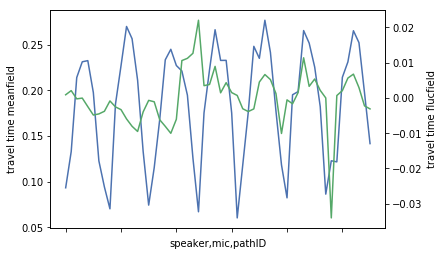

In [228]:
fig, ax = plt.subplots()
tt_meanfield.plot(ax=ax)
ax.set_ylabel('travel time meanfield')
axtwin = ax.twinx()
mask = np.abs(1-np.eye(8).flatten()).astype(bool)

test = tt_flucfield.where(mask).dropna()
test.plot(ax=axtwin, color='C1')
axtwin.set_ylabel('travel time flucfield')

# ax.set_xticks(tt_meanfield.index.get_level_values(2))
# ax.set_xticklabels(tt_meanfield.index.get_level_values(2))